\title{Emcee fitinimas 2 laipsnio plinomu}


\section{Antro laipsnio polinomo fitinimas}
Mažiausių kvadratų, labiausiai tikėtinas ir mcmc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.optimize as op

Čia surašytos naudotos funkcijos

In [2]:
def pol2(x, a, b, c):
    return a * x**2 + b * x + c

In [3]:
def lnlike(theta, x, y, yerr):
    a, b, c, lnf = theta
    model = a * x**2 + b * x + c
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2 * lnf))
    return -0.5*(np.sum((y - model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [4]:
def lnprior(theta):
    a, b, c, lnf = theta
    if 0 < a < 2 and 0.0 < b < 3 and 0.0 < c < 5.0 and\
    -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [5]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Apsibrėžiu tikrąsias a, b, c ir f vertes. Sugeneruoju duomenis.

In [6]:
#True params
a_true = 0.2
b_true = 1
c_true = 2
f_true = 0.2
#synthetic data

N = 100
x = np.sort(10*np.random.rand(N))
yerr = 0.5+2.5*np.random.rand(N)

y = a_true * x**2 + b_true * x + c_true

y += np.abs(f_true*y) * np.random.randn(N)

y += yerr * np.random.randn(N)

<ErrorbarContainer object of 3 artists>

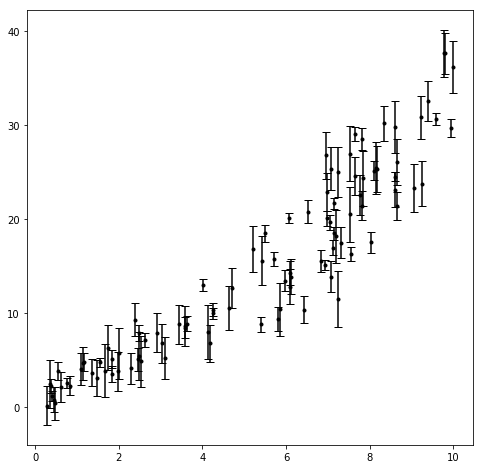

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(x, y, yerr, marker='.', linestyle='',\
             capsize=4, color='k')

\subsection{Mažiausių kvadratų fit}
Mažiausių kvadratų fit darysiu su \textit{scipy.optimize.curve_fit}. Ji leidžia atsižvelgti į sigmą.

In [8]:
params_ls, covs_ls = op.curve_fit(pol2, x, y, \
                                  sigma=yerr ** 2 * np.eye(len(yerr)))
params_lsn, covs_lsn = op.curve_fit(pol2, x, y)
#print("par = ", params_ls, "\n covs = ", covs_ls)

Palyginimui, atvaizduoju ir fit, kur nebuvo atsižvelgta į sigma.

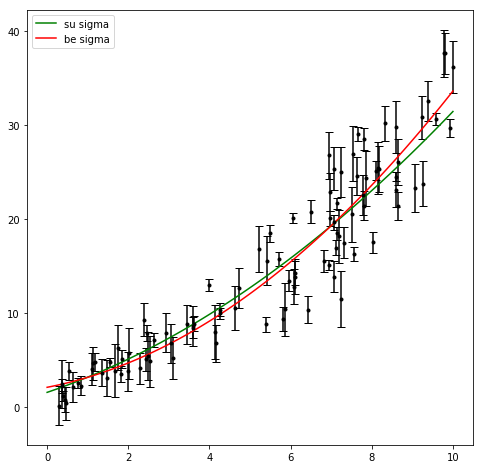

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

x_i = np.linspace(0,10, 100)
y_ls = params_ls[0] * x_i**2 + params_ls[1] * x_i + params_ls[2]
y_lsn = params_lsn[0] * x_i**2 + params_lsn[1] * x_i + params_lsn[2]

ax.errorbar(x, y, yerr, marker='.', linestyle='',\
             capsize=4, color='k')

ax.plot(x_i, y_ls, color='green', label="su sigma")
ax.plot(x_i, y_lsn, color='red', label="be sigma")
plt.legend()

\subsection{Labiausiai tikėtinas fit}

In [10]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [a_true, b_true,c_true, np.log(f_true)], args=(x, y, yerr))
a_ml, b_ml, c_ml, lnf_ml = result["x"]

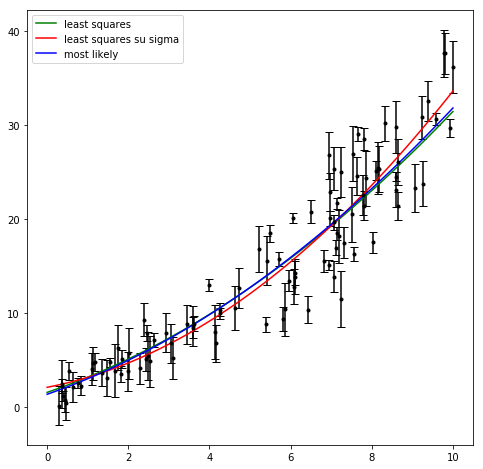

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

y_ls = params_ls[0] * x_i**2 + params_ls[1] * x_i + params_ls[2]
y_lsn = params_lsn[0] * x_i**2 + params_lsn[1] * x_i + params_lsn[2]
y_ml = a_ml * x_i**2 + b_ml * x_i + c_ml

ax.errorbar(x, y, yerr, marker='.', linestyle='',\
             capsize=4, color='k')

ax.plot(x_i, y_ls, color='green', label="least squares")
ax.plot(x_i, y_lsn, color='red', label="least squares su sigma")
ax.plot(x_i, y_ml, color='blue', label="most likely")
ax.tick_params()
plt.legend()

\subsection{MCMC fit su emcee}

In [12]:
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

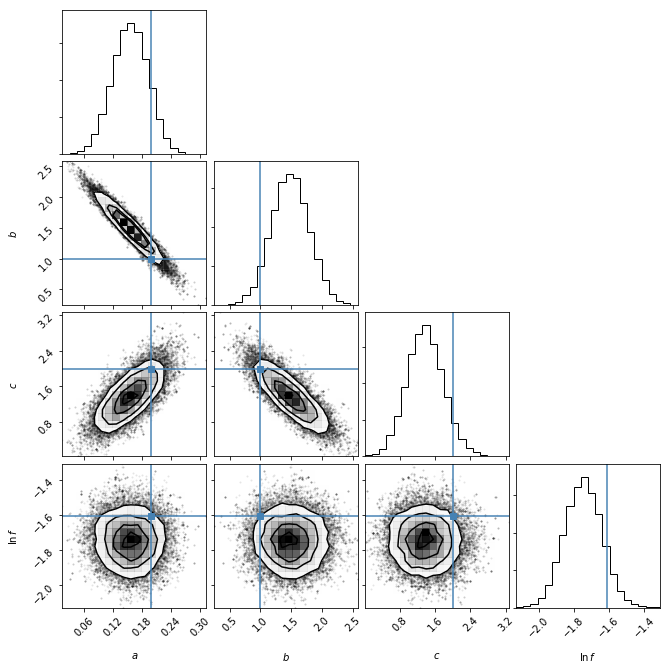

In [13]:
fig = corner.corner(samples, labels=["$a$", "$b$","$c$", "$\ln\,f$"],
                      truths=[a_true, b_true, c_true, np.log(f_true)])


(45000, 4)


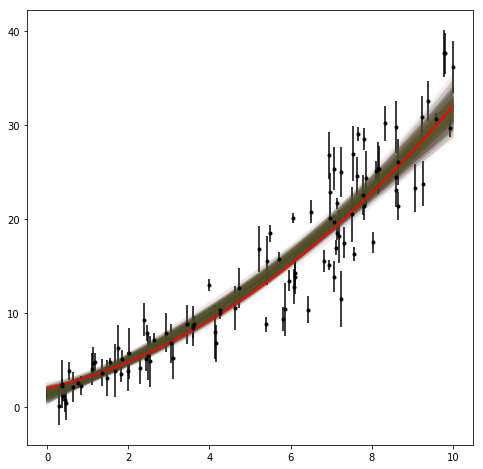

In [16]:
print(samples.shape)
'''
#x_ls = np.array([0, 10])
plt.figure(figsize=(10,10))
#for a, b, c, lnf in samples[np.random.randint(len(samples), size=500)]:
for a, b, c, lnf in samples[np.random.randint(len(samples), size=500)]:
    plt.plot(x_ls, a * x_ls**2 + b * x_ls + c, color="k", alpha=0.1)
'''
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.errorbar(x, y, yerr=yerr, fmt=".k")

for i in range(4500):
    ax.plot(x_i, samples[i,0]*x_i ** 2 + samples[i,1] * x_i + samples[i,2], alpha=0.01)
ax.plot(x_i, a_true*x_i ** 2 + b_true * x_i + c_true, color="r", lw=2, alpha=0.9)

In [15]:
samples[:, 3] = np.exp(samples[:, 3])
a_mcmc, b_mcmc, c_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
a_mcmc, b_mcmc, c_mcmc, f_mcmc

((0.15655773727855327, 0.036998403198665264, 0.03713779273101214),
 (1.4857981906639899, 0.3064032136467554, 0.3063379906993342),
 (1.371324336124205, 0.41996049882684616, 0.3993739836899062),
 (0.17440546294085285, 0.019254911304280253, 0.017493243300884698))